<p style="text-align:center;font-size:xx-large;font-weight:bold"> Exploratory data analysis example - 1C Company</p>

This notebook shows some exploratory data exploration of retail sales data in the context of predicting future sales numbers of items at different retail outlets. This data was provided by the Russian software publisher and retailer 1C Company.  

It can be viewed as an example of the use of Python with the data analysis library _pandas_, the visualization library _seaborn_, and the model explanation library _SHAP_. 

# Table of contents
  
* [Load, check and clean data](#Load,-check-and-clean-data)
* [Exploration of trends and distributions in the data](#Exploration-of-trends-and-distributions-in-the-data)
* [Model fitting and fitted model exploration](#Model-fitting-and-fitted-model-exploration)

# Load, check and clean data

## Import python packages
The first thing to do is import a standard set of Python packages for data manipulation and analysis. Pandas and NumPy are used to store and manipulate tabular data, Matplotlib and Seaborn are used for visualization, and a few standard Python libraries are imported also.

In [1]:
import itertools
import os
import re
import warnings

warnings.filterwarnings("ignore", module="seaborn")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_style("darkgrid")
sns.set_context("notebook", font_scale=1.0, rc={"axes.titlesize":13})

## Load data

First we'll list the files in the data directory.

In [2]:
DIR_PATH = "../input/competitive-data-science-predict-future-sales/"
os.listdir(DIR_PATH)

['.ipynb_checkpoints',
 'items.csv',
 'item_categories.csv',
 'sales_train.csv',
 'sample_submission.csv',
 'shops.csv',
 'test.csv']

We'll load all the files into the workspace as pandas dataframes with the same variable names as the csv files, other than "sales_train", which will be renamed to "train" to save time typing. Additionally, two Russian language text columns are replaced with English translated versions>

In [3]:
items = pd.read_csv("../input/competitive-data-science-predict-future-sales/items.csv")
item_categories = pd.read_csv(
    "../input/predict-future-sales-extra/item_categories_enhanced.csv"
)
item_categories = item_categories.drop(
    columns=["supercategory", "platform", "digital", "supercategory_id", "platform_id"]
)
train = pd.read_csv("../input/competitive-data-science-predict-future-sales/sales_train.csv")
shops = pd.read_csv("../input/predict-future-sales-extra/shops_extra.csv")
shops = shops.drop(columns="shop_name").rename(columns={"shop_name_en": "shop_name"})
test = pd.read_csv("../input/competitive-data-science-predict-future-sales/test.csv")

## Show table contents
We have a quick look at first few lines of each of the tables to get a basic idea of their contents.

In [4]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [5]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [6]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Headsets / Headphones,0
1,Accessories - PS2,1
2,Accessories - PS3,2
3,Accessories - PS4,3
4,Accessories - PSP,4


In [7]:
shops.head()

,shop_id,shop_name
0,0,"! Yakutsk Ordzhonikidze, 56 francs"
1,1,"! Yakutsk TC ""Central"" fran"
2,2,"Adygea TC ""Mega"""
3,3,"Balashikha TC ""Oktyabr-Kinomir"""
4,4,"Volga TC ""Volga Mall"""


## Merge tables  
It looks like the training data has been structured as normalized tables for efficiency. For convenience we can merge the training data into a single table by joining them on their shared fields.

In [8]:
train = train.merge(items, on='item_id', how='left')
train = train.merge(item_categories, on='item_category_id', how='left')
train = train.merge(shops, on='shop_id', how='left')

## Check and convert datatypes
We list the datatypes of the columns to check if they could be improved.

In [9]:
train.dtypes

date                   object
date_block_num          int64
shop_id                 int64
item_id                 int64
item_price            float64
item_cnt_day          float64
item_name              object
item_category_id        int64
item_category_name     object
shop_name              object
dtype: object

The date field is formatted as a string, we can convert that to the datetime dtype to enable extra datetime features such as grouping by weeks or months.

In [10]:
train["date"] = pd.to_datetime(train["date"], format="%d.%m.%Y")

The other columns have an appropriate datatype but could be downcasted to a lower-precision datatype to save memory without any loss in accuracy. This is done here with a custom downcasting function that downcasts integer columns to the smallest type that can represent all column values, and converts float-type columns to the float32 type.

In [11]:
def reduce_mem_usage(df, silent=True, float_dtype="float32"):
    def _downcast_numeric(series):
        """
        Downcast a numeric series into either the smallest possible int dtype or a specified float dtype.
        """
        if pd.api.types.is_sparse(series.dtype) is True:
            return series
        elif pd.api.types.is_numeric_dtype(series.dtype) is False:
            return series
        elif pd.api.types.is_float_dtype(series.dtype):
            series = series.astype(float_dtype)
        else:
            series = pd.to_numeric(series, downcast="integer")
        return series

    if silent is False:
        start_mem = np.sum(df.memory_usage()) / 1024 ** 2
        print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    if df.ndim == 1:
        df = _downcast_numeric(df)
    else:
        for col in df.columns:
            df.loc[:, col] = _downcast_numeric(df.loc[:, col])
    if silent is False:
        end_mem = np.sum(df.memory_usage()) / 1024 ** 2
        print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
        print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))

    return df

In [12]:
train = reduce_mem_usage(train, silent=False)
train.dtypes

Memory usage of dataframe is 246.39 MB
Memory usage after optimization is: 148.39 MB
Decreased by 39.8%


date                  datetime64[ns]
date_block_num                  int8
shop_id                         int8
item_id                        int16
item_price                   float32
item_cnt_day                 float32
item_name                     object
item_category_id                int8
item_category_name            object
shop_name                     object
dtype: object

## Check for missing values
Now we have prepared the dataframe we can check it for missing values.

In [13]:
train.isna().sum()

date                  0
date_block_num        0
shop_id               0
item_id               0
item_price            0
item_cnt_day          0
item_name             0
item_category_id      0
item_category_name    0
shop_name             0
dtype: int64

There aren't any, good!

## First look and outlier removal
The full dataset is assembled, so we can look at the first few rows to get an idea of its contents.

In [14]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name
0,2013-01-02,0,59,22154,999.000000,1.0,ЯВЛЕНИЕ 2012 (BD),37,Cinema - Blu-Ray,"Yaroslavl TC"" Altair """
1,2013-01-03,0,25,2552,899.000000,1.0,DEEP PURPLE The House Of Blue Light LP,58,Music - Vinyl,"Moscow TEC"" Atrium """
2,2013-01-05,0,25,2552,899.000000,-1.0,DEEP PURPLE The House Of Blue Light LP,58,Music - Vinyl,"Moscow TEC"" Atrium """
3,2013-01-06,0,25,2554,1709.050049,1.0,DEEP PURPLE Who Do You Think We Are LP,58,Music - Vinyl,"Moscow TEC"" Atrium """
4,2013-01-15,0,25,2555,1099.000000,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Music - CD of corporate production,"Moscow TEC"" Atrium """


It looks like the rows are individual sales counts for specific shop-item combinations on specific days, with the following columns:

* date: the date of the transaction
* date_block_num: the month of the transaction encoded as an integer
* shop_id: the shop which performed the sales, encoded as an integer
* item_id: the item which was sold or returned, encoded as an integer
* item_price: the price that the item was traded at in the shop on that day
* item_cnt_day: the net number of items that were sold in the shop that day (zero entries are omitted)
* item_name: a text string with a natural language description of the item, in Russian or English
* item_category_id: the category of the item, encoded as an integer
* item_category_name: the category of the item in English
* shop_name: an English translation of the name of the shop

We now use the pandas "describe" method to get a summary of the distribution of values in each numerical column. We'll round values to the nearest integer for clarity and append the number of unique values for each column.

In [15]:
pd.concat(
    [
        train.select_dtypes('number').describe().astype("int"),
        pd.DataFrame(train.select_dtypes('number').nunique(), columns=["nunique"]).transpose(),
    ],
    axis=0,
)

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,2935849,2935849,2935849,2935849,2935849,2935849
mean,14,33,10197,890,1,40
std,9,16,6324,1729,2,17
min,0,0,0,-1,-22,0
25%,7,22,4476,249,1,28
50%,14,31,9343,399,1,40
75%,23,47,15684,999,1,55
max,33,59,22169,307980,2169,83
nunique,34,60,21807,19992,198,84


From this we can see:
* date_block_num, shop_id and item_category_id are categorical variables numbered sequentially from zero with respectively 34, 60 and 84 unique values.
* item_id is a categorical variable with over 20,000 unique values.
* item_price has at least one negative value, which could be an error or a missing value marker.
  * Some quick investigation finds that only one entry has a negative price, which should be safe to remove.
* item_cnt_day also has one or more negative values, which could indicate item returns.
  * There are 7356 rows with negative item_cnt_day values, 0.25% of the total. These are probably valid, but it turns out that the negative values cause problems when aggregating sales (e.g. negative monthly sales figures), so we delete these here.
* item_price and item_cnt_day both contain max values much higher than their 75% percentile values, which indicates the presence of outliers or long-tailed distributions.

The very highest-valued entries of the item_price and item_cnt_month are so few in number they can be looked at individually. Judging by a quick inspection, the very highest valued entries are custom orders for large numbers of items and are probably best removed.

We remove outliers and negative values by retaining only rows with item_price and item_cnt_day values within specific thresholds.

In [16]:
train = train[(train["item_price"] > 0) & (train["item_price"] < 50000)]
train = train[(train["item_cnt_day"] > 0) & (train["item_cnt_day"] < 1000)]

## Checking the validity of shop_id and shop_name column values
The training data contains multiple shop_ids, not all of which are in the test set. To get an overview we can create a figure which plots total sales for each shop by month and displays the shop names in Russian and English. A table with a list of translated shop names is used for this. 

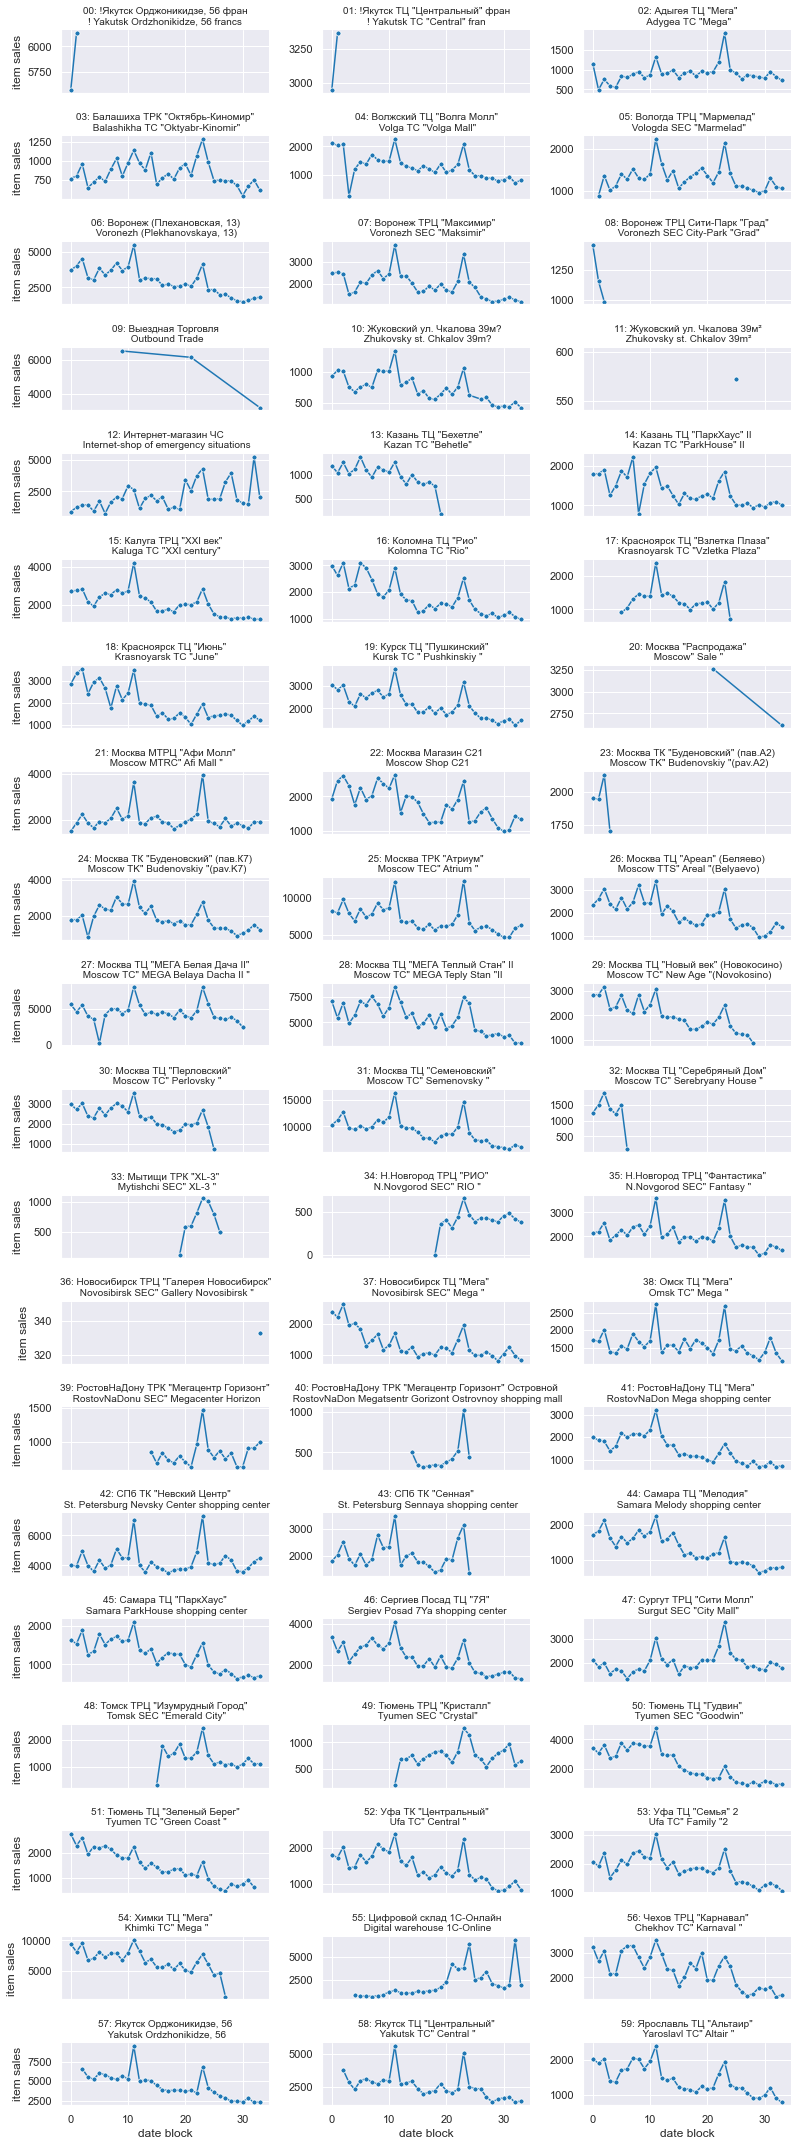

In [17]:
def sales_by_shop():
    shopsext = pd.read_csv("../input/predict-future-sales-extra/shops_extra.csv")
    shopnamedict = {
        id: f"{id:02}: {rus + chr(10) + eng}"
        for rus, eng, id in zip(
            list(shopsext["shop_name"]),
            list(shopsext["shop_name_en"]),
            list(shopsext["shop_id"]),
        )
    }
    train["shop_name_trans"] = train["shop_id"].map(shopnamedict)
    fg = sns.relplot(
        data=train.groupby(["date_block_num", "shop_name_trans"])["item_cnt_day"]
        .sum()
        .reset_index()
        .sort_values("shop_name_trans"),
        x="date_block_num",
        y="item_cnt_day",
        col="shop_name_trans",
        col_wrap=3,
        height=1.5,
        aspect=2.5,
        kind="line",
        marker=".",
        markersize=10,
        facet_kws={"sharey": False},
    )
    _ = (
        fg.set_titles("{col_name}", size="small")
        .set_ylabels("item sales")
        .set_xlabels("date block")
    )


sales_by_shop()

## Correct shop labels and remove data from unusual shops
A closer look at these plots finds several data cleaning issues, such as:
* Duplicate shops with minor name differences. Duplicates should be merged.
* Infrequently-used special category shops such as "Outbound Trade". These might distort the model if used during training.
* Some shops cease to exist before the end of the time period covered.

We will merge the duplicate shops and remove all data from shops not in the test month, for simplicity.  

(A similar check of item categories finds no data quality issues)

In [18]:
train["shop_id"] = train["shop_id"].replace({0: 57, 1: 58, 11: 10, 40: 39})
train = train.loc[train.shop_id.isin(test["shop_id"].unique()), :]

## Remove duplicate items

Finally, we'll check for remaining duplicate entries in the training data.

In [19]:
train[train.duplicated()]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name,shop_name_trans
1435367,2014-02-23,13,50,3423,999.0,1.0,"Far Cry 3 (Classics) [Xbox 360, русская версия]",23,Games - XBOX 360,"Tyumen SEC ""Goodwin""","50: Тюмень ТЦ ""Гудвин""\n Tyumen SEC ""Goodwin"""
1496766,2014-03-23,14,21,3423,999.0,1.0,"Far Cry 3 (Classics) [Xbox 360, русская версия]",23,Games - XBOX 360,"Moscow MTRC"" Afi Mall ""","21: Москва МТРЦ ""Афи Молл""\n Moscow MTRC"" Afi ..."
1671873,2014-05-01,16,50,3423,999.0,1.0,"Far Cry 3 (Classics) [Xbox 360, русская версия]",23,Games - XBOX 360,"Tyumen SEC ""Goodwin""","50: Тюмень ТЦ ""Гудвин""\n Tyumen SEC ""Goodwin"""
1866340,2014-07-12,18,25,3423,999.0,1.0,"Far Cry 3 (Classics) [Xbox 360, русская версия]",23,Games - XBOX 360,"Moscow TEC"" Atrium ""","25: Москва ТРК ""Атриум""\n Moscow TEC"" Atrium """
2198566,2014-12-31,23,42,21619,499.0,1.0,ЧЕЛОВЕК ДОЖДЯ (BD),37,Cinema - Blu-Ray,St. Petersburg Nevsky Center shopping center,"42: СПб ТК ""Невский Центр""\n St. Petersburg Ne..."


There are only 5 duplicate entries, but the fact that 4 of them are for the same product suggests that they are errors, so we might as well drop them.

In [20]:
train = train.drop_duplicates()

# Exploration of trends and distributions in the data

We can look at the the distributions of target and other features, and look for interesting relationships between features. The aim of this exploration should be to find patterns in the data that could help predict the target value, and identify the types of model that are appropriate for the prediction task.

## Creating a model training dataset by aggregating the data by month
The challenge is to predict monthly sales totals, so we should create a model training set that reproduces the test format by summing sales for each month.   

The format of the test items is a list of all possible combinations of shops and items for shops and items that recorded at least one sale in the test month, i.e. the Cartesian product of these shops and items. We recreate this by summing the sales for the Cartesian product of active shops and items sold in each month.

As before, we merge the items, categories and shops tables so these can be used as predictive features.

In [21]:
def create_testlike_train(sales_train, test=None):
    indexlist = []
    for i in sales_train.date_block_num.unique():
        x = itertools.product(
            [i],
            sales_train.loc[sales_train.date_block_num == i].shop_id.unique(),
            sales_train.loc[sales_train.date_block_num == i].item_id.unique(),
        )
        indexlist.append(np.array(list(x)))
    df = pd.DataFrame(
        data=np.concatenate(indexlist, axis=0),
        columns=["date_block_num", "shop_id", "item_id"],
    )

    # Add revenue column to sales_train
    sales_train["item_revenue_day"] = sales_train["item_price"] * sales_train["item_cnt_day"]
    # Aggregate item_id / shop_id item_cnts and revenue at the month level
    sales_train_grouped = sales_train.groupby(["date_block_num", "shop_id", "item_id"]).agg(
        item_cnt_month=pd.NamedAgg(column="item_cnt_day", aggfunc="sum"),
        item_revenue_month=pd.NamedAgg(column="item_revenue_day", aggfunc="sum"),
    )

    # Merge the grouped data with the index
    df = df.merge(
        sales_train_grouped,
        how="left",
        on=["date_block_num", "shop_id", "item_id"],
    )

    # Fill empty item_cnt entries with 0
    df.item_cnt_month = df.item_cnt_month.fillna(0)
    df.item_revenue_month = df.item_revenue_month.fillna(0)

    return df

In [22]:
df = create_testlike_train(train)

df = df.merge(items, on="item_id", how="left")
df = df.merge(item_categories, on="item_category_id", how="left")
df = df.merge(shops, on="shop_id", how="left")

We show the head of the table to check it looks ok.

In [23]:
df.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_revenue_month,item_name,item_category_id,item_category_name,shop_name
0,0,59,22154,1.0,999.0,ЯВЛЕНИЕ 2012 (BD),37,Cinema - Blu-Ray,"Yaroslavl TC"" Altair """
1,0,59,2552,0.0,0.0,DEEP PURPLE The House Of Blue Light LP,58,Music - Vinyl,"Yaroslavl TC"" Altair """
2,0,59,2554,0.0,0.0,DEEP PURPLE Who Do You Think We Are LP,58,Music - Vinyl,"Yaroslavl TC"" Altair """
3,0,59,2555,0.0,0.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Music - CD of corporate production,"Yaroslavl TC"" Altair """
4,0,59,2564,0.0,0.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,Music - Music video,"Yaroslavl TC"" Altair """


## Distribution of the target feature  

We plot an initial histogram of the target item_cnt_month feature, with a smoothed distribution estimate.

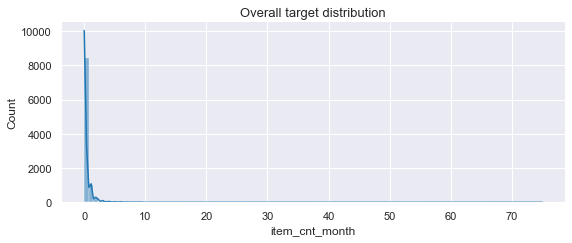

In [24]:
fg = sns.displot(
    df.sample(10000), x="item_cnt_month", bins=100, kde=True
)
_ = fg.fig.set_size_inches(9, 3)
_ = fg.ax.set(title="Overall target distribution")

The distribution clearly has a very large peak close to zero.  Creating sales counts for all possible combinations of shop and item each month might lead to lots of entries with zero sales, we should check what proportion of item counts are now zero.

In [25]:
print(f"Proportion of 0-valued targets is {df[df.item_cnt_month==0].shape[0]/df.shape[0]}.")

Proportion of 0-valued targets is 0.8457804166978585.


About 85% of target values are zero, which will clearly dominate any distribution plots. To get an idea of the distribution of non-zero values, we plot the distribution again with zero values removed.

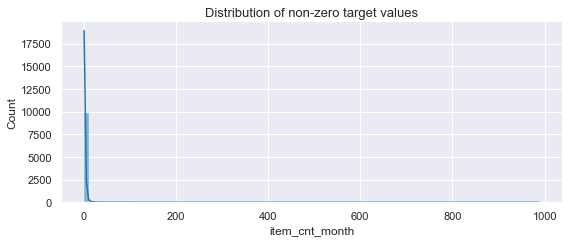

In [26]:
fg = sns.displot(
    df[df.item_cnt_month != 0].sample(10000), x="item_cnt_month", bins=100, kde=True
)
_ = fg.fig.set_size_inches(9, 3)
_ = fg.ax.set(title="Distribution of non-zero target values")

In [27]:
print(f"Proportion of targets greater than 1 is {df[df.item_cnt_month>1].shape[0]/df.shape[0]}.")

Proportion of targets greater than 1 is 0.052576717093067826.


Even with zeros removed, the target is very bottom-heavy, with only around 5% of values above 1, although a small number of items sell much more than this.  

The skewness of the distribution makes linear models unsuitable for predicting future sales of items, as assumptions for linear models will not be met. Instead, non-linear models such as decision trees or k-nearest neighbor models would be more suitable.

## Item price distribution
We can also plot the distribution of items prices. For this, we take the mean price of the item in months in which it was sold.

In [28]:
def all_shops_frame(df):
    items_all_shops = df.groupby(["date_block_num", "item_category_name", "item_id"]).agg(
        {"item_revenue_month": "mean", "item_cnt_month": "sum"}
    )
    items_all_shops = items_all_shops.assign(
        item_price_mean=lambda x: x.item_revenue_month / x.item_cnt_month
    )
    return items_all_shops

In [29]:
df_all = all_shops_frame(df)

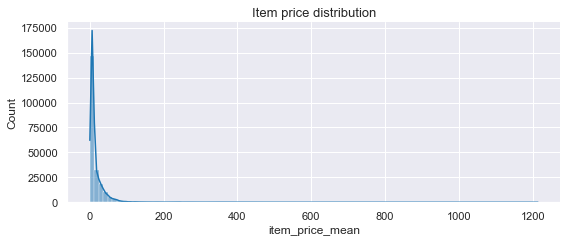

In [30]:
fg = sns.displot(df_all, x="item_price_mean", bins=100, kde=True)
_ = fg.ax.set_title("Item price distribution")
_ = fg.fig.set_size_inches(9,3)

Prices are also highly skewed towards zero. We can display the distribution more clearly by using a log scale.

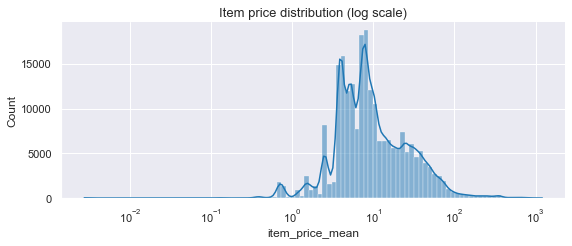

In [31]:
fg = sns.displot(df_all, x="item_price_mean", bins=100, kde=True, log_scale=True)
_ = fg.ax.set_title("Item price distribution (log scale)")
_ = fg.fig.set_size_inches(9,3)

Here we can see that the price distribution is approximately lognormal with a peak slightly below 10.
## Joint distribution of item prices and sales
Finally, we can also plot the joint distribution of monthly items sales and mean prices, again using log scales for clarity.

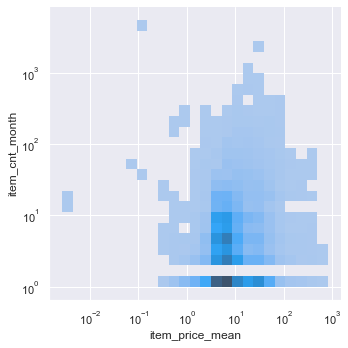

In [32]:
fg = sns.displot(df_all.sample(10000), x="item_price_mean",y="item_cnt_month", bins=25, log_scale=True)

This reveals no strong overall associations between price and sales, although associations may exist in subgroups of the data.  

Outliers are also apparent.

## Overall sales trends over time
Plotting total sales counts per month shows clear downwards and seasonal trends. Mean sales per item, however, shows a less pronounced downward trend.

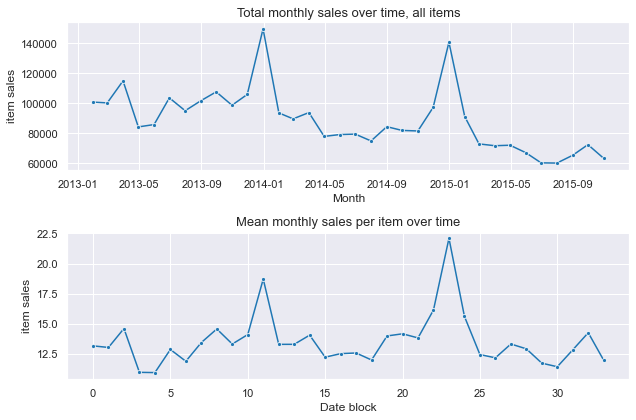

In [33]:
fig, axes = plt.subplots(2, 1, figsize=(9, 6))
sales_resampled = train.groupby(pd.Grouper(key="date", freq="m")).item_cnt_day.sum()
_ = sns.lineplot(data=sales_resampled, marker=".", markersize=8, ax=axes[0])
_ = axes[0].set(xlabel="Month", ylabel="item sales", title="Total monthly sales over time, all items")

sales_resampled = df_all.groupby("date_block_num").item_cnt_month.mean()
_ = sns.lineplot(data=sales_resampled, marker=".", markersize=8, ax=axes[1])
_ = axes[1].set(xlabel="Date block", ylabel="item sales", title="Mean monthly sales per item over time")
fig.tight_layout()

Mean sales per item can also be decomposed into seasonal and continuous trends using the _statsmodels_ package. This show a clear yearly seasonal trend (particularly a peak around the winter holidays) and an overall downwards trend that can be assumed to related to the rise of internet and digital-only sales.

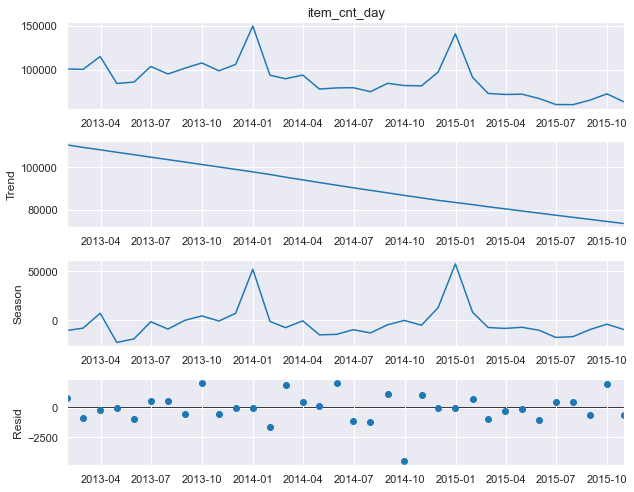

In [34]:
from statsmodels.tsa.seasonal import STL
sales_resampled = train.groupby(pd.Grouper(key="date", freq="m")).item_cnt_day.sum()
result = STL(sales_resampled).fit()
fig = result.plot()
fig.set_size_inches((9, 7))
fig.tight_layout()

The overall sales trend is clearly downwards, but there are differences at the item category level. Compare the following trend and seasonal decomposition plots for games for the PS3 and PS4, which show falling and rising trends.  

In any case, including a seasonal variable (i.e. a month feature) should help the prediction model capture seasonal trends.

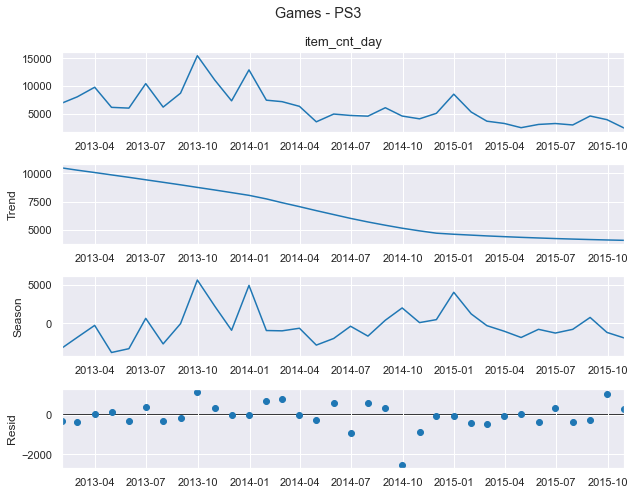

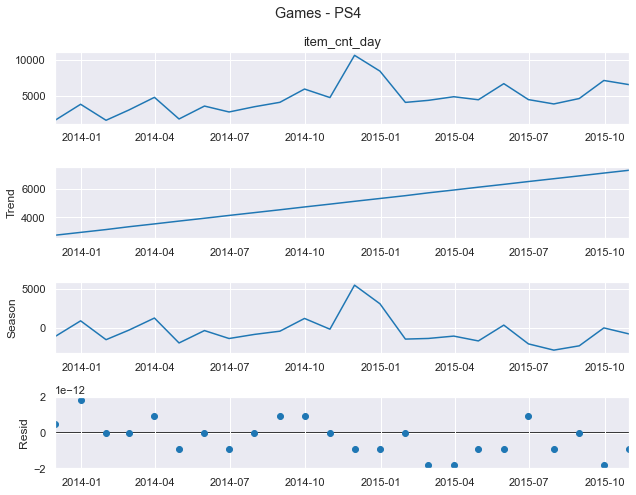

In [35]:
for catname in ["Games - PS3", "Games - PS4"]:
    sales_resampled = (
        train.query(f"item_category_name=='{catname}'")
        .groupby(pd.Grouper(key="date", freq="m"))
        .item_cnt_day.sum()
    )
    result = STL(sales_resampled).fit()
    fig = result.plot()
    fig.set_size_inches((9, 7))
    plt.suptitle(catname)
    fig.tight_layout()
del (sales_resampled, result)

## Sales by item category
Each item is assigned one of 80+ categories which identify what kind of product it is and what format it is for. Information about these categories could be predictive because different types of item are likely to sell in different amounts.

First we plot mean sales and revenue per item in each category across all shops for the last year of sales data and sort by descending magnitude.

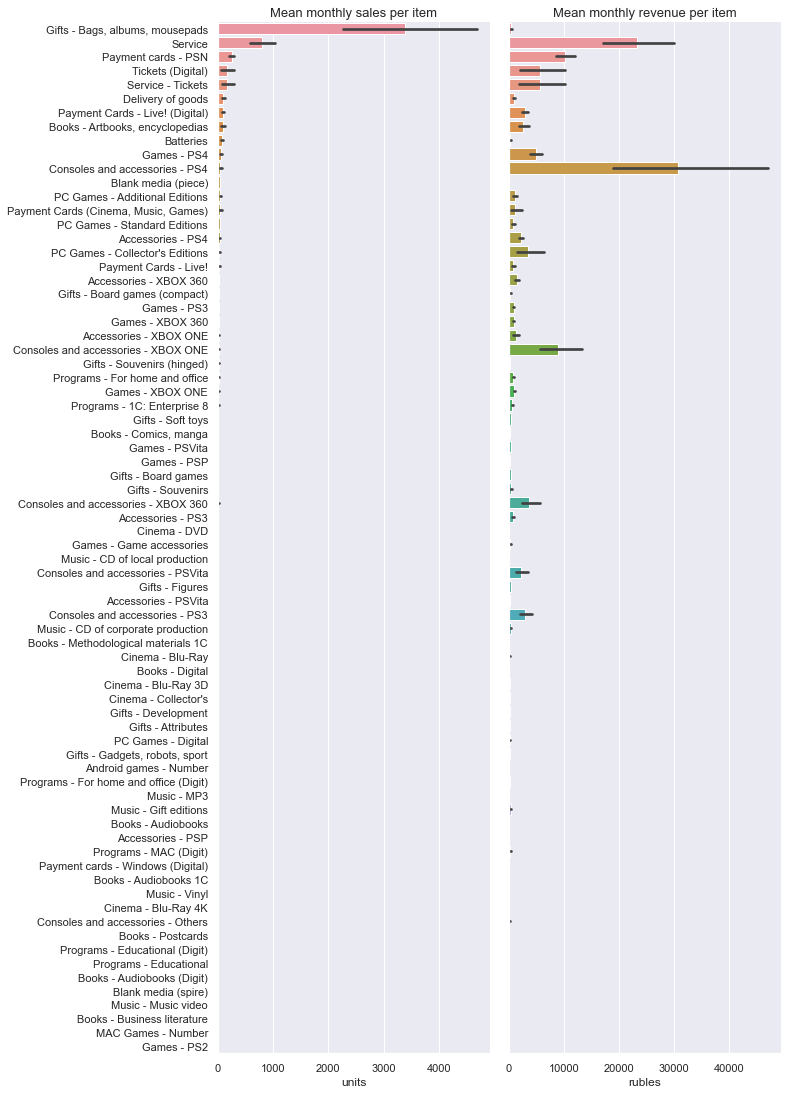

In [36]:
selection = df_all.query("date_block_num>21").drop(columns="item_price_mean")
sortidx = selection.groupby("item_category_name")["item_cnt_month"].agg(np.mean).argsort()
cat_info = selection.reset_index().melt(id_vars=["date_block_num", "item_category_name", "item_id"])
fg = sns.catplot(
    data=cat_info, y="item_category_name", x="value", sharex=False, kind="bar", estimator=np.mean,
    order=sortidx[sortidx[::-1]].index, col="variable", col_order=["item_cnt_month", "item_revenue_month"]
)
_ = fg.figure.set_size_inches(12, 18)
_ = fg.axes[0][0].set(title="Mean monthly sales per item", xlabel="units", ylabel=None)
_ = fg.axes[0][1].set(title="Mean monthly revenue per item", xlabel="rubles")

Most obviously this plot shows that items in one particular category - "Gifts - bags, albums, mousepads" - have a much higher sales volume than items in other categories, but comparitively little revenue. This category contains few items and denotes low cost items such as promotional bags and mousemats.  

Economic importance may be better represented by plotting summed rather than mean values in each category. Doing so shows that movies and games are the highest-selling categories overall, with PS4 games accounting for the most revenue. As well as being predictive in itself, this information could be useful for deciding what categories to prioritize when building predictive models or allocating promotional resources.  

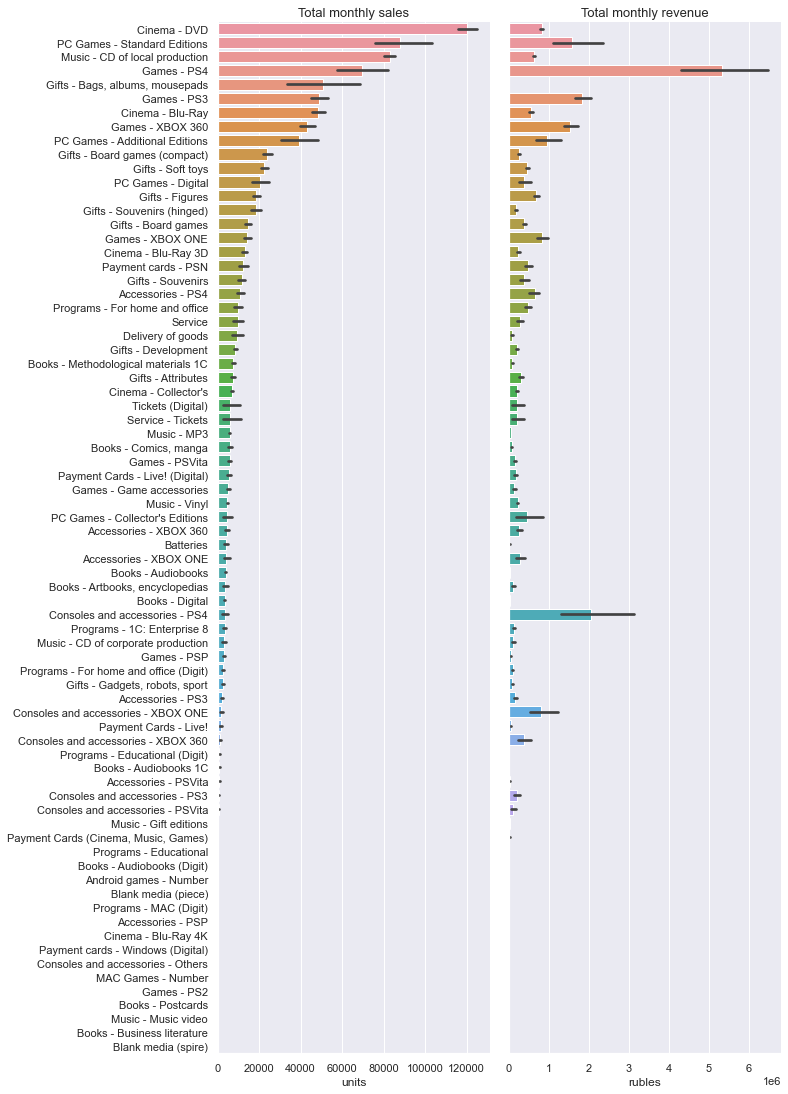

In [37]:
selection = df_all.query("date_block_num>21").drop(columns="item_price_mean")
sortidx = selection.groupby("item_category_name")["item_cnt_month"].agg(np.sum).argsort()
cat_info = selection.reset_index().melt(id_vars=["date_block_num", "item_category_name", "item_id"])
fg = sns.catplot(
    data=cat_info, y="item_category_name", x="value", sharex=False, kind="bar", estimator=np.sum,
    order=sortidx[sortidx[::-1]].index, col="variable", col_order=["item_cnt_month", "item_revenue_month"]
)
_ = fg.figure.set_size_inches(12, 18)
_ = fg.axes[0][0].set(title="Total monthly sales", xlabel="units", ylabel=None)
_ = fg.axes[0][1].set(title="Total monthly revenue", xlabel="rubles")

## Sales by shop category
Summed sales can similarly be plotted when data is grouped according to shop.

As with categories, this shows that a small number of shops, paricularly those in Moscow, sell much more items overall than others. All else being equal, an item sold in these shops can be predicted to sell in greater quantities.  

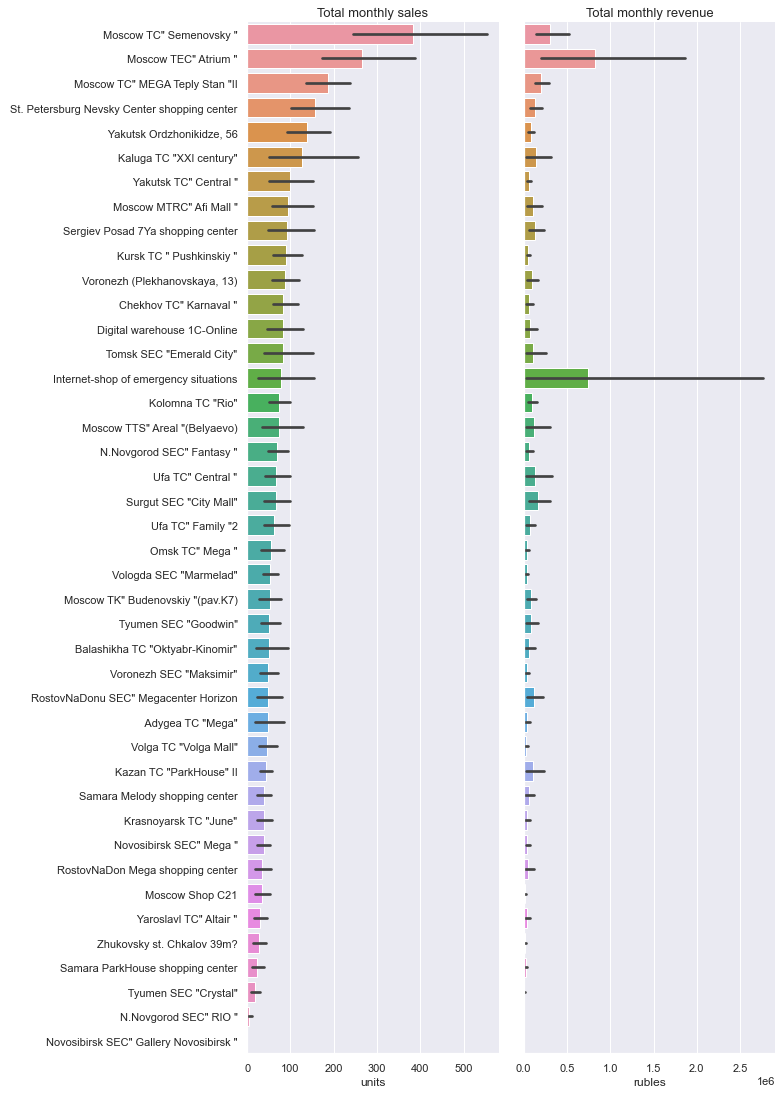

In [38]:
selection = (
    df.query("date_block_num>21").sample(10000)
    .groupby(["date_block_num", "shop_name", "item_id"])[
        ["item_cnt_month", "item_revenue_month"]
    ]
    .mean()
    .reset_index()
)
sortidx = selection.groupby("shop_name")["item_cnt_month"].agg(np.sum).argsort()
cat_info = selection.melt(
    id_vars=["date_block_num", "shop_name", "item_id"]
)
fg = sns.catplot(
    data=cat_info,
    y="shop_name",
    x="value",
    sharex=False,
    kind="bar",
    estimator=np.sum,
    order=sortidx[sortidx[::-1]].index,
    col="variable",
    col_order=["item_cnt_month", "item_revenue_month"],
)
_ = fg.figure.set_size_inches(12, 18)
_ = fg.axes[0][0].set(title="Total monthly sales", xlabel="units", ylabel=None)
_ = fg.axes[0][1].set(title="Total monthly revenue", xlabel="rubles")

## Shop - category sales profile and decomposition of sales
Some shops sell more than others, and items in some item categories sell more than others, but are there differences in the relative quantities of items in each category that shops sell?  

The individual summed sales per category profile of each shop can be created and is plotted here as a heatmap.

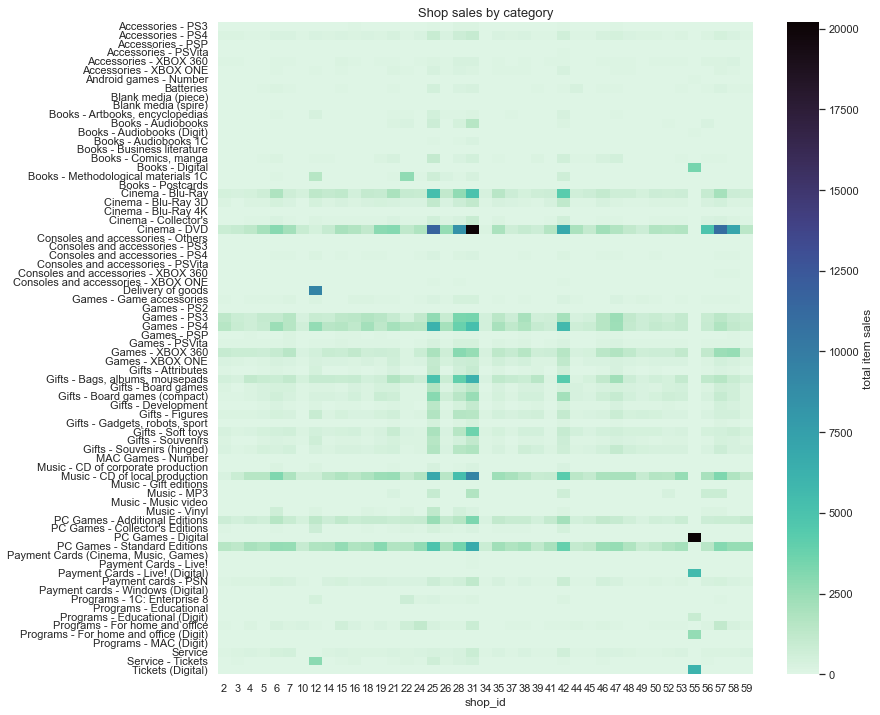

In [39]:
cat_info = train.query("shop_id!=36 & date_block_num>21").pivot_table(
    values="item_cnt_day",
    columns="shop_id",
    index="item_category_name",
    fill_value=0,
    aggfunc="sum",
)
fig, ax = plt.subplots(figsize=(12, 12))
ax = sns.heatmap(
    cat_info,
    cmap="mako_r",
    ax=ax,
    xticklabels=True,
    yticklabels=True,
    cbar_kws={"label": "total item sales"},
)
ax = ax.set(ylabel=None, title="Shop sales by category")

## PCA decomposition and clustering of shops  
The vertical stripes in the heatmap indicate shops that differ from the mean in some way, but high-dimensional data like this can be difficult to understand without some kind of summary.  

Principle component analysis (PCA) lets us decompose high dimensional data into a low dimensional representation that makes it easier to get an overview of patterns in the data. Although the values in the shop-item category sales data do not have the normal distribution assumed by the PCA algorithm, this can be partially corrected by log transforming the data.

In [40]:
from sklearn.decomposition import PCA

def plot_pca(data, n_components, pc1 = 0, pc2 = 1):
    pca = PCA(n_components=n_components)
    transformed = pca.fit_transform(data)
    transformed = pd.DataFrame(transformed)
    features = list(range(1, pca.n_components_ + 1))
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    _ = sns.barplot(x=features, y=pca.explained_variance_ratio_ * 100, ax=axes[0,0])
    _ = axes[0,0].set(
        xlabel="PCA features",
        ylabel="variance %",
        title="Explained variance by principle component",
        xticklabels=features,
    )
    pcs = [(0, 1), (2, 3), (4, 5)]
    for i, pc in enumerate(pcs, start=1):
        pc1 = pc[0]
        pc2 = pc[1]
        x=transformed[pc1]
        y=transformed[pc2]
        _ = sns.scatterplot(x=x, y=y, ax=axes[i//2, i%2])
        _ = axes[i//2, i%2].set(
            xlabel=f"Component {pc1 + 1} score",
            ylabel=f"Component {pc2 + 1} score",
            title="Shop principle component scores",
        )
        for j, txt in enumerate(data.index.to_list()):
            axes[i//2, i%2].annotate(str(txt), (x[j], y[j]))
    return pca

Below are the results of the PCA-decomposition of the shop-item_category sales profiles using the implementation in scikit-learn. The top-left plot shows the proportion of the overall variance explained by each component, while the remaining 3 plots show the shops plotted on scatter plots by their scores on the first 6 principle components.

The explained variance plot shows that around 75% of the differences between the shops can be explained by two linear components.

Plotting the shops according to their scores on the first two components shows that the shop with shop_id 55 is particularly unlike the other shops, while plotting the shops according to their other components reveals that shop 12 is also an outlier. This makes intuitive sense, as these are internet or virtual shops rather than physical stores.

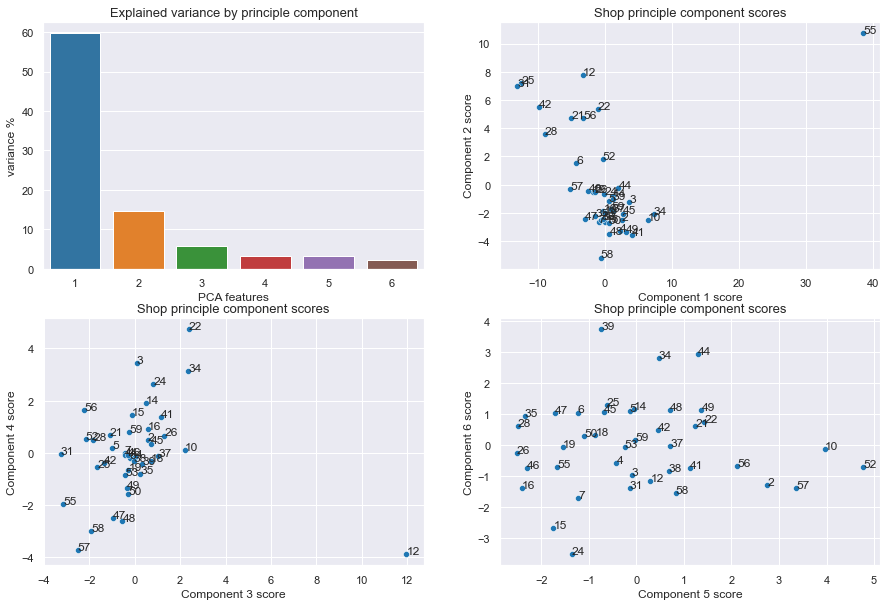

In [41]:
start_month=21
end_month=32
cat_info = df[df.shop_id.isin(test.shop_id.unique())].query(f"date_block_num>{start_month} & date_block_num<={end_month}")
cat_info = cat_info.pivot_table(values='item_cnt_month', columns='item_category_name', index='shop_id', fill_value=0, aggfunc='sum')
pca = plot_pca(cat_info.apply(lambda x: np.log(x + 1)), 6)

Insight into what these components correspond to can be gained by plotting the components that map the component scores to the original data. We do this here for the two largest components, and sort the the component mappings for clarity. 

Looking at component 1, we see that this is mostly highly weighted on "digital" categories, i.e. non-physical online downloads, which fits with the internet store 55 having a very high score in this dimension. Further components reveal other dimensions in the differences between shops, such as the sales of music and audiobook products being correlated.

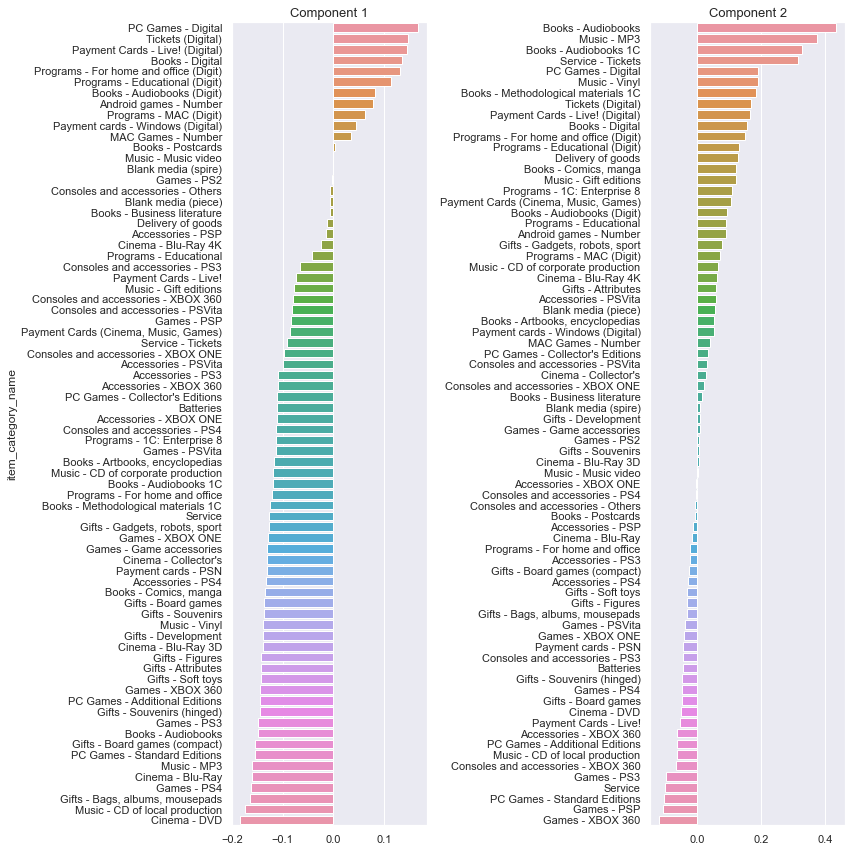

In [42]:
def plot_component(pca, component_num, ax):
    sortidx = np.argsort(pca.components_[component_num])[::-1]
    _ = sns.barplot(
        y=cat_info.columns[sortidx],
        x=pca.components_[component_num][sortidx],
        orient="h",
        ax=ax,
    )
    _ = ax.set(title=f"Component {component_num+1}")

fig, axes = plt.subplots(1, 2, figsize=(12, 12))

plot_component(pca, 0, axes[0])
plot_component(pca, 1, axes[1])

_ = axes[1].set_ylabel(None)
fig.tight_layout()

## Sales as a function of item age

The age of items when they are sold can be approximately calculated by subtracting from the sale date the first date or month on which they were sold.  

In [43]:
def item_shop_age_months(matrix):
    matrix["item_age"] = matrix.groupby("item_id")["date_block_num"].transform(
    lambda x: x - x.min()
    )
    matrix["new_item"] = matrix["item_age"] == 0
    matrix["new_item"] = matrix["new_item"].astype("int8")
    matrix["shop_age"] = (
        matrix.groupby("shop_id")["date_block_num"]
        .transform(lambda x: x - x.min())
        .astype("int8")
    )
    matrix["new_shop"] = matrix.shop_age == 0
    matrix["new_shop"] = matrix["new_shop"].astype("int8")
    return matrix

df = item_shop_age_months(df)

Total monthly item sales as a function of item age is plotted below for all items, and separately for items in two representative categories.

Plotting total monthly item sales as a function of their ages shows that items tend to sell most when they are new and then decline to a plateau about 1 year later. The slightly lower sales in the first compared to the second month is attributable to items not always being available for the whole first month.  

It is also evident that this trend for items to sell most shortly after their release is more evident for some categories, such as movies, compared to others.

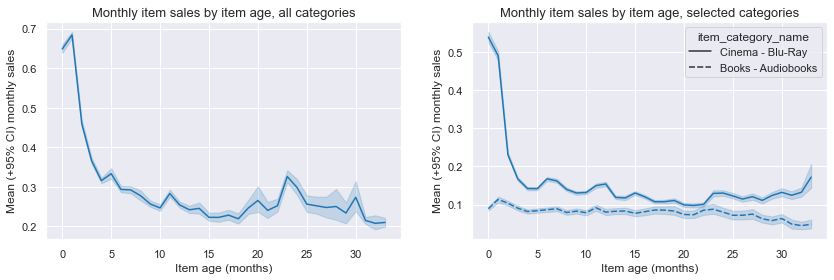

In [44]:
fig, axes = plt.subplots(1,2, figsize = (14,4))
_ = sns.lineplot(data=df, x="item_age", y="item_cnt_month", ax=axes[0])
_ = axes[0].set(title = "Monthly item sales by item age, all categories", xlabel="Item age (months)", ylabel="Mean (+95% CI) monthly sales")
_ = sns.lineplot(data=df[df.item_category_name.isin(("Books - Audiobooks", "Cinema - Blu-Ray"))], x="item_age", y="item_cnt_month",
             style="item_category_name", ax=axes[1])
_ = axes[1].set(title = "Monthly item sales by item age, selected categories", xlabel="Item age (months)", ylabel="Mean (+95% CI) monthly sales")

## Predicting sales from historical sales
Even when taking the decline of sales volume over time into account, it seems likely that products that sell well in one month are likely to also sell well in the following month. A column can be created which contains the sales figures from the previous month for the same shop-item combination.  

We can create a regression plot of sales counts as a function of previous months sales, for a sample items which are at least a month old. We use log scales on the axes for clarity and plot the estimate of the central tendency (mean) of item_cnt_month.

In [45]:
def simple_lag_feature(matrix, lag_feature, lags):
    for lag in lags:
        newname = lag_feature + f"_lag_{lag}"
        print(f"Adding feature {newname}")
        targetseries = matrix.loc[:, ["date_block_num", "item_id", "shop_id"] + [lag_feature]]
        targetseries["date_block_num"] += lag
        targetseries = targetseries.rename(columns={lag_feature: newname})
        matrix = matrix.merge(
            targetseries, on=["date_block_num", "item_id", "shop_id"], how="left"
        )
        matrix.loc[
            (matrix.item_age >= lag) & (matrix.shop_age >= lag) & (matrix[newname].isna()),
            newname,
        ] = 0
    return matrix

In [46]:
df = simple_lag_feature(df, 'item_cnt_month', lags=[1])

Adding feature item_cnt_month_lag_1


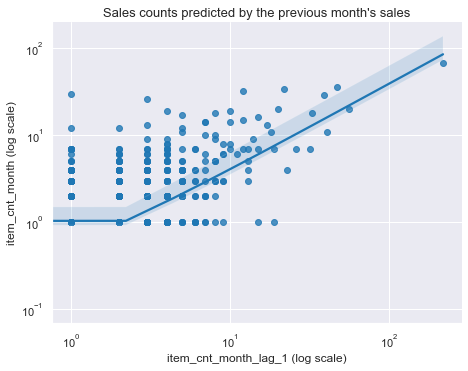

In [47]:
def regplot(x, y, title):
    a = df.query("item_age>0 & shop_age>0").sample(10000)
    fg = sns.lmplot(x=x, y=y, data=a)
    _ = fg.figure.set_size_inches(7, 5)
    _ = fg.ax.set(
        xscale="log",
        yscale="log",
        title=title,
        xlabel=f"{x} (log scale)",
        ylabel=f"{y} (log scale)",
    )


x = "item_cnt_month_lag_1"
y = "item_cnt_month"
title = "Sales counts predicted by the previous month's sales"
regplot(x, y, title)

## Moving average of previous sales.
Single shop-item sales in individual months are mostly low-valued and tend to be noisy. To reduce this noise, windowing methods can be used to calculate a historical mean of sales as a weighted sum of the sales from multiple previous months. An example showing multiple types of window is shown below.

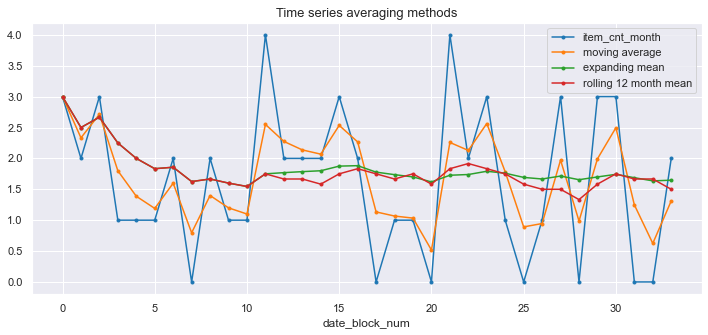

In [48]:
shop_id = 16
item_id = 482
im = df.query(f"shop_id=={shop_id} & item_id=={item_id}")[['date_block_num', 'item_cnt_month']]
im['moving average'] = im['item_cnt_month'].ewm(halflife=1).mean()
im['expanding mean'] = im['item_cnt_month'].expanding().mean()
im['rolling 12 month mean'] = im['item_cnt_month'].rolling(window=12, min_periods=1).mean()
im = im.set_index('date_block_num')
ax = im.plot(figsize=(12,5), marker='.', title='Time series averaging methods')

In [49]:
def add_rolling_stats(
    df,
    features,
    window=12,
    kind="rolling",
    argfeat="item_cnt_month",
    aggfunc="mean",
    rolling_aggfunc="mean",
    dtype="float16",
    reshape_source=True,
    lag_offset=0,
):
    def rolling_stat(
        df,
        source,
        feats,
        feat_name,
        window=12,
        argfeat="item_cnt_month",
        aggfunc="mean",
        dtype=dtype,
        lag_offset=0,
    ):
        # Calculate a statistic on a windowed section of a source table,  grouping on specific features
        store = []
        for i in range(2 + lag_offset, 35 + lag_offset):
            if len(feats) > 0:
                mes = (
                    source[source.date_block_num.isin(range(max([i - window, 0]), i))]
                    .groupby(feats)[argfeat]
                    .agg(aggfunc)
                    .astype(dtype)
                    .rename(feat_name)
                    .reset_index()
                )
            else:
                mes = {}
                mes[feat_name] = (
                    source.loc[
                        source.date_block_num.isin(range(max([i - window, 0]), i)), argfeat
                    ]
                    .agg(aggfunc)
                    .astype(dtype)
                )
                mes = pd.DataFrame(data=mes, index=[i])
            mes["date_block_num"] = i - lag_offset
            store.append(mes)
        store = pd.concat(store)
        df = df.merge(store, on=feats + ["date_block_num"], how="left")
        return df

    """ An issue when using windowed functions is that missing values from months when items recorded no sales are skipped rather than being correctly
    treated as zeroes. Creating a pivot_table fills in the zeros."""
    if (reshape_source == True) or (kind == "ewm"):
        source = df.pivot_table(
            index=features + ["date_block_num"],
            values=argfeat,
            aggfunc=aggfunc,
            fill_value=0,
            dropna=False,
        ).astype(dtype)
        for g in features:
            firsts = df.groupby(g).date_block_num.min().rename("firsts")
            source = source.merge(firsts, left_on=g, right_index=True, how="left")
            # Set values before the items first appearance to nan so they are ignored rather than being treated as zero sales.
            source.loc[
                source.index.get_level_values("date_block_num") < source["firsts"], argfeat
            ] = float("nan")
            del source["firsts"]
        source = source.reset_index()
    else:
        source = df

    if kind == "rolling":
        feat_name = (
            f"{'_'.join(features)}_{argfeat}_{aggfunc}_rolling_{rolling_aggfunc}_win_{window}"
        )
        print(f'Creating feature "{feat_name}"')
        return rolling_stat(
            df,
            source,
            features,
            feat_name,
            window=window,
            argfeat=argfeat,
            aggfunc=rolling_aggfunc,
            dtype=dtype,
            lag_offset=lag_offset,
        )
    elif kind == "expanding":
        feat_name = f"{'_'.join(features)}_{argfeat}_{aggfunc}_expanding_{rolling_aggfunc}"
        print(f'Creating feature "{feat_name}"')
        return rolling_stat(
            df,
            source,
            features,
            feat_name,
            window=100,
            argfeat=argfeat,
            aggfunc=aggfunc,
            dtype=dtype,
            lag_offset=lag_offset,
        )
    elif kind == "ewm":
        feat_name = f"{'_'.join(features)}_{argfeat}_{aggfunc}_ewm_hl_{window}"
        print(f'Creating feature "{feat_name}"')
        source[feat_name] = (
            source.groupby(features)[argfeat]
            .ewm(halflife=window, min_periods=1)
            .agg(rolling_aggfunc)
            .to_numpy(dtype=dtype)
        )
        del source[argfeat]
        #         source = source.reset_index()
        source["date_block_num"] += 1 - lag_offset
        return df.merge(source, on=["date_block_num"] + features, how="left")

In [50]:
df = add_rolling_stats(df, ["shop_id", "item_id"], kind="ewm", window=1)
df = add_rolling_stats(df, ["shop_id", "item_id"], window=12)

Creating feature "shop_id_item_id_item_cnt_month_mean_ewm_hl_1"
Creating feature "shop_id_item_id_item_cnt_month_mean_rolling_mean_win_12"


We create windowed 12-month average and exponential moving average (in which recent months are weighed more than less recent months) sales count features and display regression plots below. 

In [51]:
def create_apply_ME(
    matrix, grouping_fields, lags=[1], target="item_cnt_day_avg", aggfunc="mean"
):
    for lag in lags:
        newname = "_".join(grouping_fields + [target] + [aggfunc] + [f"lag_{lag}"])
        print(f"Adding feature {newname}")
        me_series = (
            matrix.groupby(["date_block_num"] + grouping_fields)[target]
            .agg(aggfunc)
            .rename(newname)
            .reset_index()
        )
        me_series["date_block_num"] += lag
        matrix = matrix.merge(me_series, on=["date_block_num"] + grouping_fields, how="left")
        del me_series
        matrix[newname] = matrix[newname].fillna(0)
        for g in grouping_fields:
            firsts = matrix.groupby(g).date_block_num.min().rename("firsts")
            matrix = matrix.merge(firsts, left_on=g, right_index=True, how="left")
            matrix.loc[
                matrix["date_block_num"] < (matrix["firsts"] + (lag)), newname
            ] = float("nan")
            del matrix["firsts"]
    return matrix

In [52]:
df = create_apply_ME(df, ["item_id"], target="item_cnt_month")

Adding feature item_id_item_cnt_month_mean_lag_1


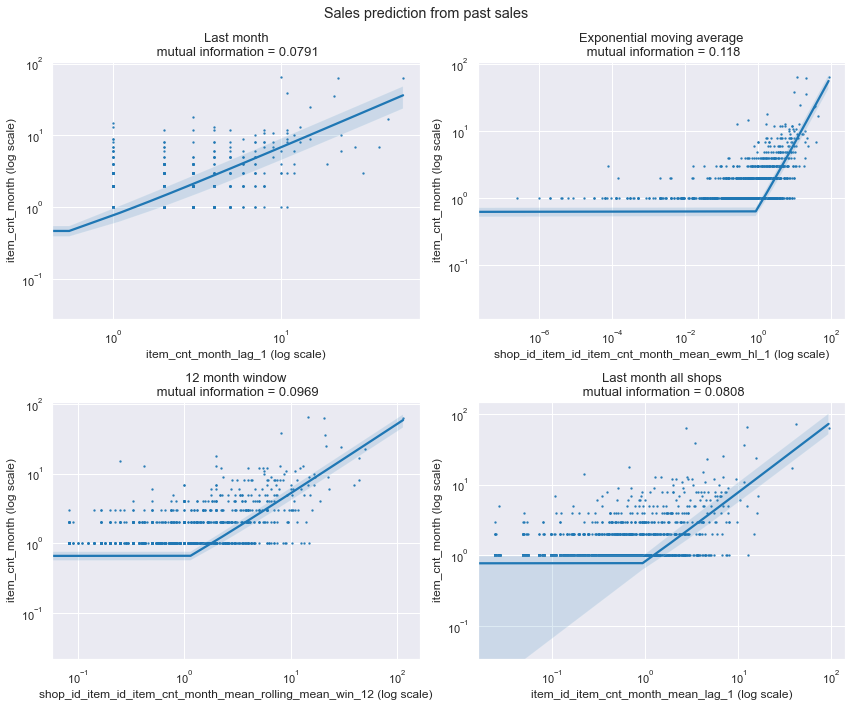

In [53]:
from sklearn.feature_selection import mutual_info_regression
warnings.filterwarnings("ignore", module="sklearn")


fig, axes = plt.subplots(2, 2, figsize=(12, 10))


def regplot(data, x, y, title, ax=None):
    score = mutual_info_regression(data[x].to_numpy().reshape(-1, 1), data[y].to_numpy())[0]
    score = float(score)
    ax = sns.regplot(x=x, y=y, data=data, ax=ax, fit_reg=True, scatter_kws={"s": 2})
    _ = ax.set(
        xscale="log",
        yscale="log",
        title=title + f"\n mutual information = {score:.3}",
        xlabel=f"{x} (log scale)",
        ylabel=f"{y} (log scale)",
    )


x = "item_cnt_month_lag_1"
y = "item_cnt_month"
title = "Last month"
data = df.query("item_age>0 & shop_age>1").sample(10000)
regplot(data, x, y, title, ax=axes[0][0])
title = "Exponential moving average"
regplot(data, "shop_id_item_id_item_cnt_month_mean_ewm_hl_1", y, title, axes[0][1])
title = "12 month window"
regplot(data, "shop_id_item_id_item_cnt_month_mean_rolling_mean_win_12", y, title, axes[1][0])
title = "Last month all shops"
regplot(data, "item_id_item_cnt_month_mean_lag_1", y, title, axes[1][1])
_ = plt.suptitle("Sales prediction from past sales")
_ = plt.tight_layout()

## The problem of new items
Historical sales figures are obviously not directly available for items in their first month of availability, so information about sales of similar items must be used instead. Ideally, multiple measures of similarity should be found and tested.

The item_category_id field can be used to group similar items, and the shop_id field can be used to find items sold in the same shop. These can be combined with the item_age engineered feature to calculate mean first-month sales counts for products grouped by item category or shop. This is plotted below for the last available year of sales data.

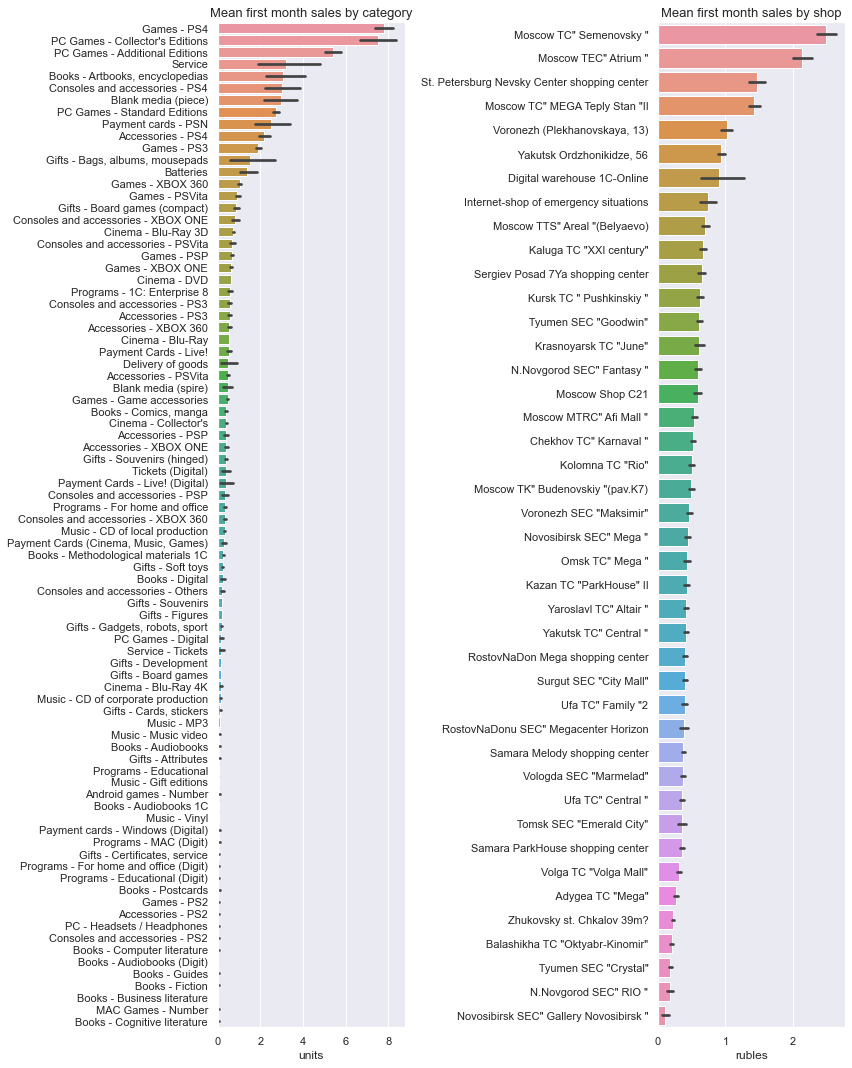

In [54]:
selection = df.query("new_item==True")
fig, axes = plt.subplots(1, 2, figsize=(12,15))
sortidx = selection.groupby("item_category_name")["item_cnt_month"].agg(np.mean).argsort()
_ = sns.barplot(
    data=selection, y="item_category_name", x="item_cnt_month", estimator=np.mean,
    order=sortidx[sortidx[::-1]].index, ax=axes[0]
)
sortidx = selection.groupby("shop_name")["item_cnt_month"].agg(np.mean).argsort()
_ = sns.barplot(
    data=selection, y="shop_name", x="item_cnt_month", estimator=np.mean,
    order=sortidx[sortidx[::-1]].index, ax=axes[1]
)
_ = axes[0].set(title="Mean first month sales by category", xlabel="units", ylabel=None)
_ = axes[1].set(title="Mean first month sales by shop", xlabel="rubles", ylabel=None)
fig.tight_layout()

As before for items of all ages, the mean new item sales count can also be calculated for each item category - shop combination, plotted below as a heat map.

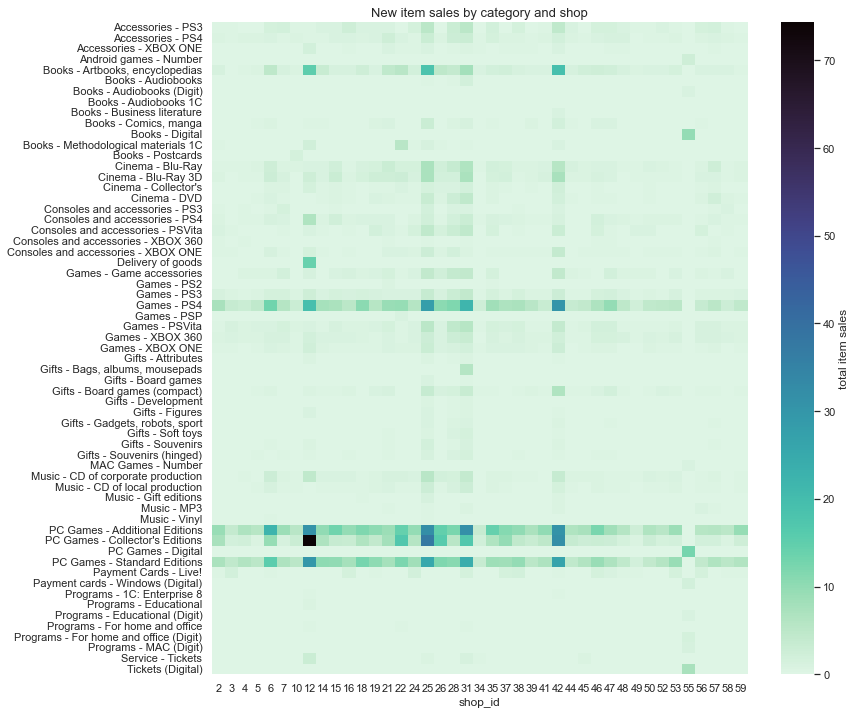

In [55]:
cat_info = df.query("shop_id!=36 & date_block_num>21 & item_age==0").pivot_table(
    values="item_cnt_month",
    columns="shop_id",
    index="item_category_name",
    fill_value=0,
    aggfunc="mean",
)
fig, ax = plt.subplots(figsize=(12, 12))
ax = sns.heatmap(
    cat_info,
    cmap="mako_r",
    ax=ax,
    xticklabels=True,
    yticklabels=True,
    cbar_kws={"label": "total item sales"},
)
ax = ax.set(ylabel=None, title="New item sales by category and shop")

### Using text features to find similar items

In addition to the information contained in the item categories and shop identities, all items have an associated item_name text feature, which contains a short description of the item that often includes things such as its title, format (e.g. PS4 or PS3) and language. Information can be potentially be extracted from this text string to group similar items.  

To aid extraction of information from text it is useful to clean the text of irrelevant special characters and punctuation, excess blank spaces, low-information words such as "the", removing diacritics such as accents over letters, and converting all text to lowercase. If necessary this can be performed by regular expression operations, as demonstrated here:

In [56]:
from nltk.corpus import stopwords

all_stopwords = stopwords.words("russian") + stopwords.words("english")


def clean_text(string):
    string = re.sub(r"[^\w\s]", "", string)
    string = re.sub(r"\s{2,}", " ", string)
    tokens = string.lower().split()
    tokens = [t for t in tokens if t not in all_stopwords]
    return " ".join(tokens)


items["item_name_clean"] = items["item_name"].apply(clean_text)

items.loc[1000:, ["item_name", "item_name_clean"]].head()

,item_name,item_name_clean
1000,"3D Action Puzzle ""Зомби"" Уборщик",3d action puzzle зомби уборщик
1001,"3D Action Puzzle ""Зомби"" Шахтер",3d action puzzle зомби шахтер
1002,"3D Action Puzzle ""Техника"" Бомбардировщик",3d action puzzle техника бомбардировщик
1003,"3D Action Puzzle ""Техника"" Вертолет",3d action puzzle техника вертолет
1004,"3D Action Puzzle ""Техника"" Гоночная машинка",3d action puzzle техника гоночная машинка


### Word and n-gram features
One way that the item_name field could be used is by extracting individual words or n-grams (groups of sequential words) and treating them as individual binary features. Doing this creates a very large number of features so some kind of filtering is necessary, such as specifying minimum numbers of occurences of a word feature, or setting a threshold on a measure of relevance to the target feature, such as correlation.  

Below is an example of the 1 and 2-ngrams producted from a single item_name text string.

In [57]:
from sklearn.feature_extraction.text import CountVectorizer

def create_item_id_bow_matrix(items):
    all_stopwords = stopwords.words("russian")
    all_stopwords = all_stopwords + stopwords.words("english")

    vectorizer = CountVectorizer(stop_words=all_stopwords, ngram_range=(1,2))
    X = vectorizer.fit_transform(items.loc[:, "item_name_clean"])
    X = pd.DataFrame.sparse.from_spmatrix(X)
    print(f"{len(vectorizer.vocabulary_)} ngrams found in all items")
    featuremap = {
        col: "ng: " + token
        for col, token in zip(
            range(len(vectorizer.vocabulary_)), vectorizer.get_feature_names()
        )
    }
    X = X.rename(columns=featuremap)
    X.index = items.index
    return X

items_short = items.loc[4000:4000,:]
X = create_item_id_bow_matrix(items_short) 
pd.concat((items_short["item_name"], X), axis=1)

5 ngrams found in all items


,item_name,ng: jethro,ng: jethro tull,ng: lp,ng: tull,ng: tull lp
4000,JETHRO TULL This Was LP,1,1,1,1,1


### Grouping items with similar names
Items with different item_ids are often related to each other, such as being different versions of the same video game or movie, and so are likely to have related sales figures. This can be taken advantage of by grouping similar items together based on their item_names.  

The Python package TheFuzz implements fuzzy string matching to measure the similarity of sequences of words. This similarity measure can be used to group related items together into a single category. This "item name group" feature can then be used as other categorical features.  

Below is a short extract of the list of items with their associated name group category designations, showing related items assigned to the same category value.

In [58]:
from fuzzywuzzy import fuzz

def partialmatchgroups(items, sim_thresh):
    def strip_brackets(string):
        string = re.sub(r"\(.*?\)", "", string)
        string = re.sub(r"\[.*?\]", "", string)
        return string

    items = items.copy()
    items["nc"] = items.item_name.apply(strip_brackets)
    items["ncnext"] = np.concatenate((items["nc"].to_numpy()[1:], np.array([""])))

    def partialcompare(s):
        return fuzz.partial_ratio(s["nc"], s["ncnext"])

    items["partialmatch"] = items.apply(partialcompare, axis=1)
    # Assign groups
    grp = 0
    for i in range(items.shape[0]):
        items.loc[i, "item_name_group"] = grp
        if items.loc[i, "partialmatch"] < sim_thresh:
            grp += 1
    items = items.drop(columns=["nc", "ncnext", "partialmatch"])
    items['item_name_group'] = items['item_name_group'].apply(int)
    return items

items = partialmatchgroups(items, 65)

In [59]:
items.query("item_id>3565")[["item_name", "item_name_group"]].head(10)

,item_name,item_name_group
3566,"Fuse [Xbox 360, английская версия]",1362
3567,G Data Internet Security 2013 (1ПК / 1 год) (G...,1363
3568,G Data Internet Security 2013 (3ПК / 1 год) (G...,1363
3569,GABIN The Best Of Gabin 2CD,1364
3570,GABRIEL PETER New Blood Live In London Blu-Ray,1365
3571,GAHAN DAVE & SOULSAVERS Angels & Ghosts,1366
3572,GAHAN DAVE & SOULSAVERS Angels & Ghosts (фирм.),1366
3573,"GALLIANO, RICHARD Piazzola Forever Septet DVD ...",1367
3574,GARBAGE Not Your Kind Of People,1368
3575,GARBAGE Absolute Garbage DVD,1369


## The problem of non-stationarity of category effects  
Categorical features such as name groups and shop ids have useful predictive information, but the relationship between category values and the target variable is not consistent over the training data, as items, item categories and shops increase or (more often) decline in popularity over time, as can be seen when plotting mean sales of music item categories.

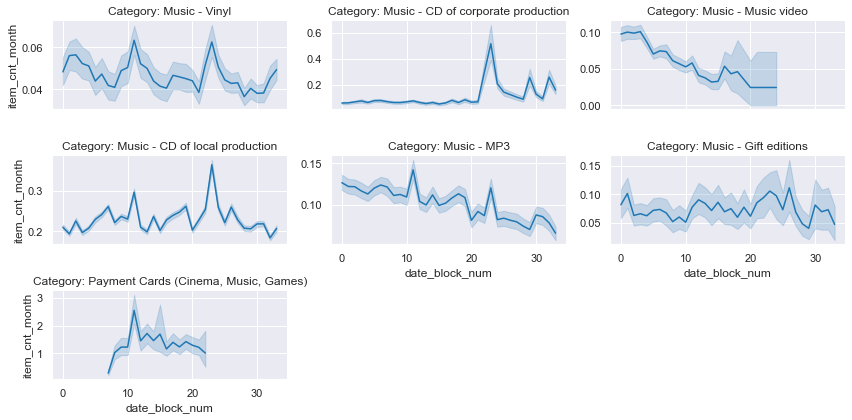

In [60]:
fg = sns.relplot(
    data=df[df["item_category_name"].apply(lambda x: "music" in x.lower())],
    x="date_block_num",
    y="item_cnt_month",
    kind="line",
    col="item_category_name",
    col_wrap=3,
    height=2,
    aspect=2,
    facet_kws={"sharey":False},
)
fg = fg.set_titles("Category: {col_name}")

## Mean encoding
Theoretically, a model could learn the interactions between individual category values and time periods, but for categorical features with high numbers of values, such as item identities and name groups, this could require very complex models and cause problems with overfitting.  

To save the predictive model having to learn the individual relationships between individual categories and specific time periods, a useful solution is to turn categorical features into numerical features by reencoding each value of the category as the mean of the target variable for training items in the same category, for some time window. As with individual items, different time windows can be used.  

Below are example windowed mean encodings for 3 values of the item category name feature using 3 different temporal windows.

In [61]:
df = add_rolling_stats(df, ["item_category_name"], kind="ewm", window=1)
df = add_rolling_stats(df, ["item_category_name"], window=12)
df = add_rolling_stats(df, ["item_category_name"], window=1)

Creating feature "item_category_name_item_cnt_month_mean_ewm_hl_1"
Creating feature "item_category_name_item_cnt_month_mean_rolling_mean_win_12"
Creating feature "item_category_name_item_cnt_month_mean_rolling_mean_win_1"


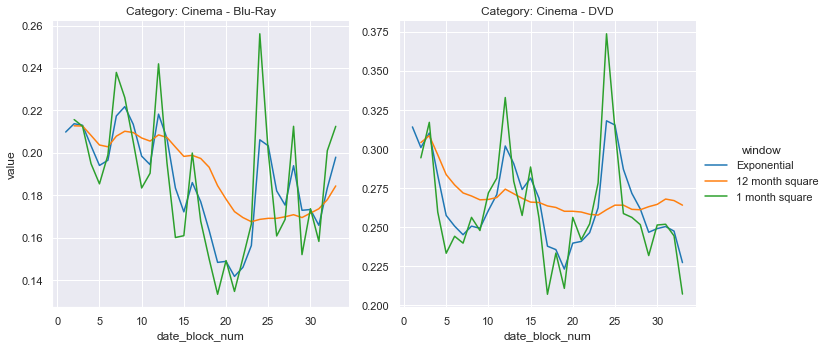

In [62]:
features = [
    "item_category_name_item_cnt_month_mean_ewm_hl_1",
    "item_category_name_item_cnt_month_mean_rolling_mean_win_12",
    "item_category_name_item_cnt_month_mean_rolling_mean_win_1",
]
data = df.groupby(["date_block_num", "item_category_name"])[features].mean()
newnames = ["Exponential", "12 month square", "1 month square"]
data = data.rename(columns={old:new for old, new in zip(features, newnames)})

data = data.reset_index().melt(id_vars=["date_block_num", "item_category_name"], value_vars=newnames, var_name="window")

querycats = ["Cinema - DVD", "Cinema - Blu-Ray"]

fg = sns.relplot(
    data=data.loc[data.item_category_name.isin(querycats), :],
    x="date_block_num",
    y="value",
    hue="window",
    kind="line",
    col="item_category_name",
    col_wrap=2,
    facet_kws={"sharey":False},
#     title="Windowed mean encodings"
)
fg = fg.set_titles("Category: {col_name}")

# Model fitting and fitted model exploration
The next step after exploratory data analysis should be the creation of a predictive model. Predictive models are obviously useful for planning actions, but a fitted model can also be used for further data exploration by extracting how the model relates features to the final prediction.  

## Model explanations with SHAP
Here we use the powerful model explanation package SHAP (SHapley Additive exPlanations) to gain additional insights about predictors of item sales. The model explained by SHAP is a LightGBM regressor, a gradient boosted decision tree model.  

First a pre-prepared training frame is loaded and used to train the LightGBM regressor.

In [63]:
df = pd.read_pickle("data/df_analysis.pkl")

# Split train and validation sets from the feature matrix, month 33 used as validation set
keep_from_month = 2  # The first couple of months are dropped because of distortions to their features (e.g. wrong item age)
test_month = 33
dropcols = [
    "shop_id",
    "item_id",
    #     "new_item",
]  # The features are dropped to reduce overfitting

valid = df.drop(columns=dropcols).loc[df.date_block_num == test_month, :]
train = df.drop(columns=dropcols).loc[df.date_block_num < test_month, :]
train = train[train.date_block_num >= keep_from_month]
X_train = train.drop(columns="item_cnt_month")
y_train = train.item_cnt_month
X_valid = valid.drop(columns="item_cnt_month")
y_valid = valid.item_cnt_month
del train, valid, df

# These hyperparameters were found by using the hyperparameter optimization framework Optuna to optimize hyperparameters for the validation set.
params = {
    "num_leaves": 966,
    "cat_smooth": 45.01680827234465,
    "min_child_samples": 27,
    "min_child_weight": 0.021144950289224463,
    "max_bin": 214,
    "learning_rate": 0.01,
    "subsample_for_bin": 300000,
    "min_data_in_bin": 7,
    "colsample_bytree": 0.8,
    "subsample": 0.6,
    "subsample_freq": 5,
    "n_estimators": 8000,
}

In [64]:
import lightgbm as lgbm

warnings.filterwarnings("ignore", module="lightgbm")
model = lgbm.LGBMRegressor(**params)

categoricals = [
    "item_category_id",
    "month",
]

# Fit the booster using early stopping
eval_set = [(X_train, y_train), (X_valid, y_valid)]
early_stopping_rounds = 30

model.fit(
    X_train,
    y_train,
    eval_set=eval_set,
    eval_metric=["rmse"],
    verbose=100,
    categorical_feature=categoricals,
    early_stopping_rounds=early_stopping_rounds,
)

Training until validation scores don't improve for 30 rounds
[100]	training's rmse: 0.856163	training's l2: 0.733015	valid_1's rmse: 0.80707	valid_1's l2: 0.651363
[200]	training's rmse: 0.752276	training's l2: 0.565919	valid_1's rmse: 0.754368	valid_1's l2: 0.569071
[300]	training's rmse: 0.711774	training's l2: 0.506623	valid_1's rmse: 0.744477	valid_1's l2: 0.554246
[400]	training's rmse: 0.687697	training's l2: 0.472927	valid_1's rmse: 0.742502	valid_1's l2: 0.551309
[500]	training's rmse: 0.671048	training's l2: 0.450306	valid_1's rmse: 0.741354	valid_1's l2: 0.549606
Early stopping, best iteration is:
[561]	training's rmse: 0.662931	training's l2: 0.439477	valid_1's rmse: 0.740871	valid_1's l2: 0.54889


LGBMRegressor(cat_smooth=45.01680827234465, colsample_bytree=0.8,
              learning_rate=0.01, max_bin=214, min_child_samples=27,
              min_child_weight=0.021144950289224463, min_data_in_bin=7,
              n_estimators=8000, num_leaves=966, subsample=0.6,
              subsample_for_bin=300000, subsample_freq=5)

A SHAP explainer object is attached to the fitted model and used to generate SHAP values, which quantify the effect of each of the features on each prediction.

In [65]:
import shap

warnings.filterwarnings("ignore", module="shap")

n = 10000  # Takes around an 1 1/2 hours for 10000 rows
sample = X_train.sample(n)
explainer = shap.Explainer(model)
shap_values = explainer(sample)
shap.initjs()

## Feature importance ranking with beeswarm plots
The beeswarm plots below show a summary plot of the effect of each features on each prediction, and ranks the features by overall importance. Each prediction is represented by a point next to each feature name, with the position of the point on the left-right axis indicating the increase or decrease over the baseline prediction caused by the feature value, and the color of the point indicating the value of the feature. For example, a red marker towards the right hand side of the plot indicates that the feature had a high value and caused an increase in the prediction.  

Here, the top feature is _shop_id_item_id_item_cnt_month_mean_ewm_hl_1_, which is the exponential moving average of previous sales for the same shop-item combination, with the expected relationship of higher previous sales predicting higher future sales. The fact that the model chose this as the most predictive feature confirms the predictive power of the moving average.  

The second most predictive feature, _shop_id_item_category_id_new_item_item_cnt_month_mean_rolling_mean_win_12_ (the name is automatically generated) is a feature that contains the 12-month mean of sales of items with the same category in the same shop, restricted to either new (i.e. first month) items or non-new items depending on whether the item to be predicted is new or not. This is likely to be particularly valuable for predicting sales of new items, a hypothesis which can be explored with further visualizations.

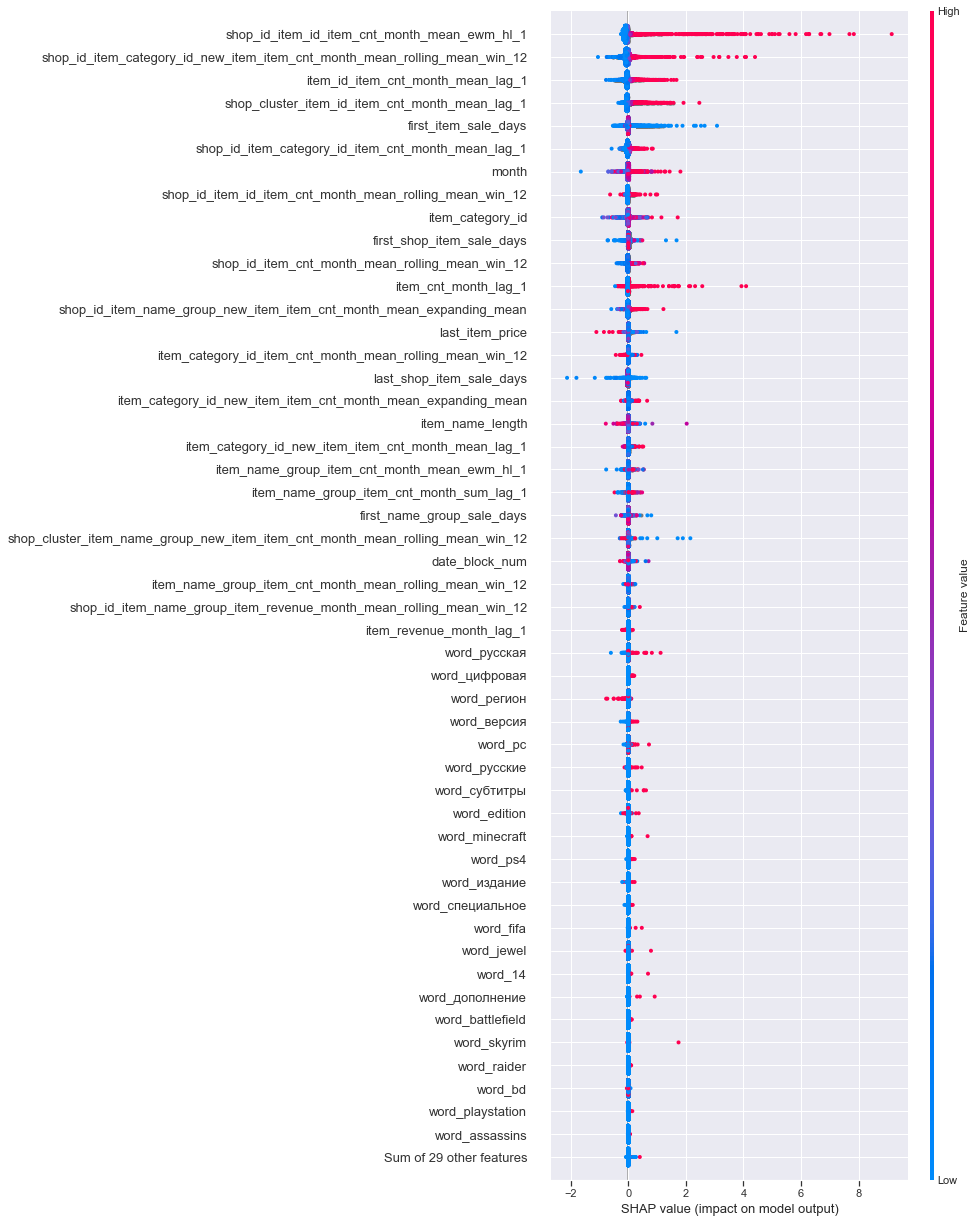

In [66]:
shap.plots.beeswarm(shap_values, max_display=50)

## Taking a closer look at predictor effects with dependence plots
A clearer view of the relationships between the target feature and one or more predictors can be gained with dependence plots.  

The following plot shows the relationship between the exponential moving average shop-item sales feature and predictions, showing an approximately linear relationship with increasing variance as feature values increase.

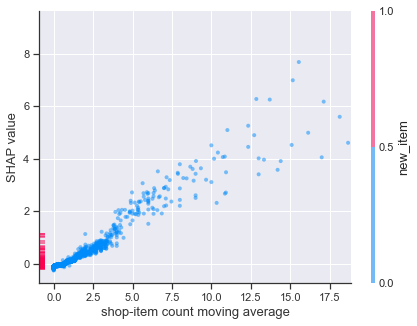

In [67]:
fix, ax = plt.subplots(figsize=(7,5))
_ = shap.dependence_plot(
    "shop_id_item_id_item_cnt_month_mean_ewm_hl_1",
    shap_values=shap_values.values,
    features=shap_values.data,
    feature_names=sample.columns.to_list(),
    interaction_index="new_item",
    ax = ax,
    xmax="percentile(99.9)", show=False,
    alpha=0.5
)
_ = ax.set_ylabel("SHAP value")
_ = ax.set_xlabel("shop-item count moving average")

A dependence plot can also vizualize interactions between two predictor features by varying point color according to a second variable. Below is plotted the shop-item_category-new_item 12 month windowed mean, with new items coloured red and non-new items coloured blue. We hypothesized that this feature would be particularly valuable for new items, which is confirmed by the steeper slope of the line that can be traced through the red points in the graph.

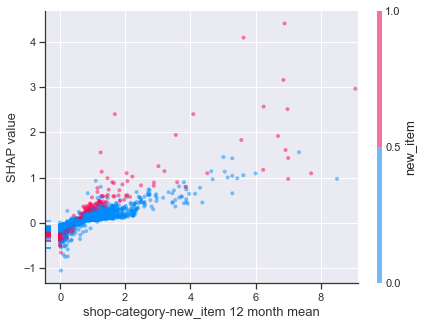

In [68]:
fix, ax = plt.subplots(figsize=(7,5))
shap.dependence_plot(
    "shop_id_item_category_id_new_item_item_cnt_month_mean_rolling_mean_win_12",
    shap_values=shap_values.values,
    features=shap_values.data,
    feature_names=sample.columns.to_list(),
    interaction_index="new_item",
    ax=ax,
    xmax="percentile(99.9)", show=False,
    alpha=0.5
)
_ = ax.set_ylabel("SHAP value")
_ = ax.set_xlabel("shop-category-new_item 12 month mean")

## Automatic detection of feature interactions
SHAP can also automatically calculate which other feature had the greatest interaction with a given feature when generating predictions. The dependence plot below shows the main effect of the "first_item_sale_days" feature, which gives the number of days between the first recorded sale of an item and the first day of the prediction month. This feature shows a main effect of predicting higher sales for newer items, which decreases over time. SHAP identifies as the main interaction feature _shop_cluster_item_id_item_cnt_month_mean_lag_1_, a feature which contains the mean sales of the same item in similar shops, plotting higher values of this feature in red. Looking at the plot, it can be observed that red points tend to be higher than blue points at low values of the main x-axis feature, and lower at higher values of the main feature, indicating that the main trend of decreasing sales with item age is more pronounced for high-selling items.

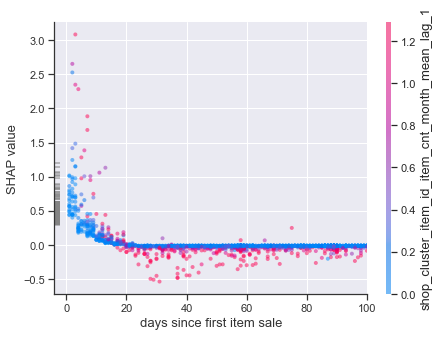

In [69]:
fix, ax = plt.subplots(figsize=(7,5))
shap.dependence_plot(
    "first_item_sale_days",
    shap_values=shap_values.values,
    features=shap_values.data,
    feature_names=sample.columns.to_list(),
    interaction_index="auto",
    ax=ax,
    xmax=100, show=False,
    alpha=0.5
)
_ = ax.set_ylabel("SHAP value")
_ = ax.set_xlabel("days since first item sale")